# Customer Churn Prediction



In [1]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


In [52]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


## Data Wrangling

In [3]:
def wrangle(file_path):
  # create a dataframe
  df = pd.read_csv(file_path)

  # Drop columns with high cardinality
  drop_cols = ['customerID']

  df = df.drop(columns=drop_cols)

  # change TotalCharges datatype from object to numerical
  df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')

  # drop null values
  df = df.dropna()

  return df

In [4]:
# read data to a dataframe
df = wrangle('/content/drive/MyDrive/Colab Notebooks/KCB/WA_Fn-UseC_-Telco-Customer-Churn.csv')

## Exploratory Data Analysis

In [5]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# check cardinality
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

In [7]:
# checking data types
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [8]:
# check null values and drop the null values if present
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
# Calculate churn distribution
churn_counts = df['Churn'].value_counts(normalize=True)*100

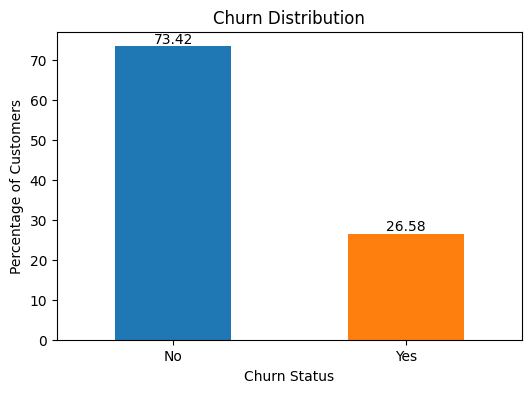

In [10]:
plt.figure(figsize=(6, 4))

# Plot bar chart for churn distribution
ax = churn_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Churn Distribution')
plt.xlabel('Churn Status')
plt.ylabel('Percentage of Customers')
plt.xticks(rotation=0)

# Add text annotations on top of each bar
for p in ax.patches:
    rounded_height = round(p.get_height(), 2)
    ax.annotate(str(rounded_height), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

The distribution of churn shows that 73.42% of customers did not churn while 26.58% did

In [11]:
# distribution of gender by Churn
churn_counts_by_gender = df.groupby('gender')['Churn'].value_counts().unstack()

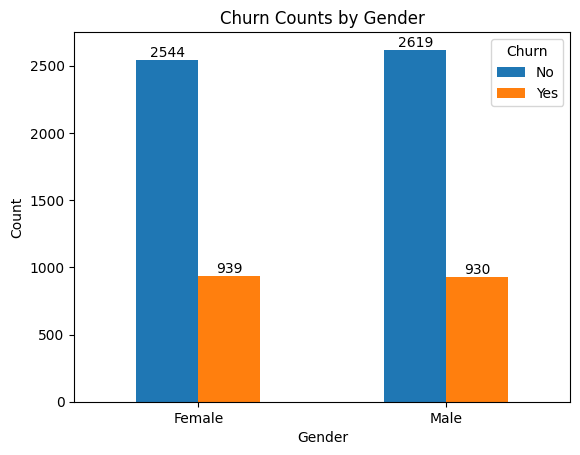

In [12]:
# Plot
ax = churn_counts_by_gender.plot(kind='bar', stacked=False)
plt.title('Churn Counts by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x labels
plt.legend(title='Churn')

# Add text annotations on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()


In [13]:
# Calculate churn distribution by contract type
churn_by_contract = (df.groupby('Contract')['Churn'].value_counts(normalize=True)*100).unstack()

<Figure size 800x600 with 0 Axes>

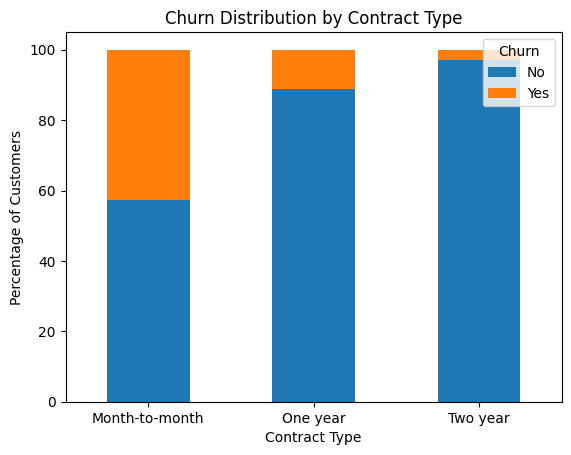

In [14]:
# Plotting
plt.figure(figsize=(8, 6))

# Plot bar plot for churn distribution by contract type
churn_by_contract.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'])
plt.title('Churn Distribution by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Percentage of Customers')
plt.xticks(rotation=0)
plt.legend(title='Churn', loc='upper right')
plt.show()

The above plot shows that the rate of churn was highest for month to month contracts and lowest for those with two year contracts.

In [54]:
# check correlation for numerical columns
df_numericals = df.copy()

In [57]:
df_numericals.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [55]:
df_numericals.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [58]:
# change data types from object to numericals
cols = ['gender', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

encoder = OrdinalEncoder()

# encoding
for col in cols:
  df_numericals[col] = encoder.fit_transform(df_numericals[col])

In [59]:
df_numericals.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [20]:
# drop the target variable
df_numericals.drop(columns='Churn', inplace=True)

In [50]:
df_numericals.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,29.85,29.85
1,2,0,2,1,34,2,2,1,2,2,2,1,1,1,2,2,2,56.95,1889.50
2,2,0,2,1,2,2,2,1,2,1,1,1,1,1,1,1,2,53.85,108.15
3,2,0,2,1,45,1,1,1,2,2,2,2,1,1,2,2,3,42.30,1840.75
4,1,0,2,1,2,2,2,2,1,2,1,1,1,1,1,1,1,70.70,151.65


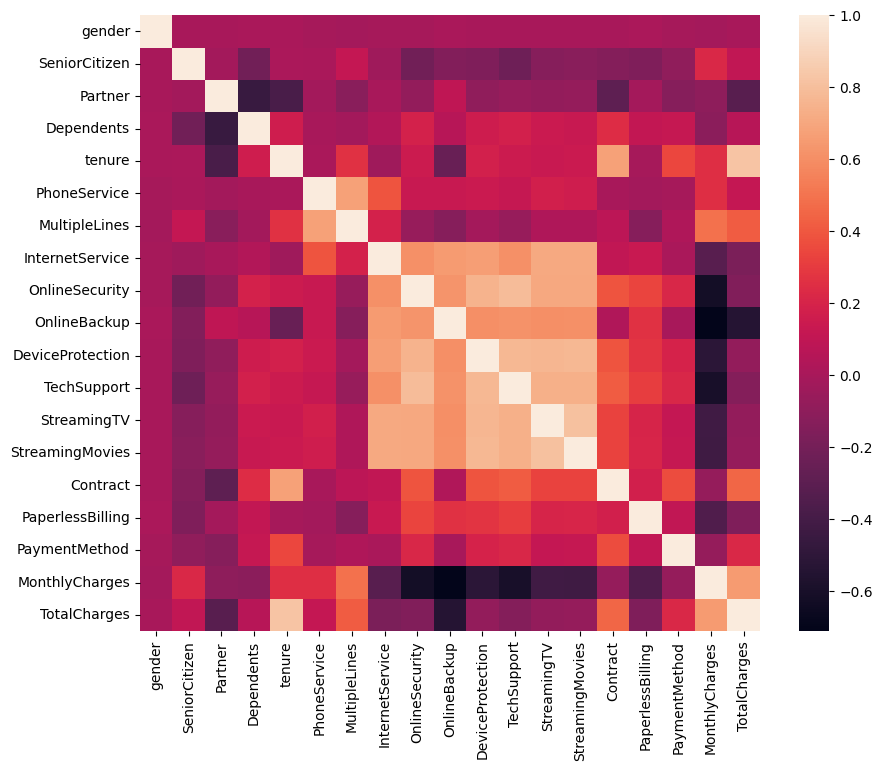

In [21]:
# Check the correlation
correlation = df_numericals.corr()

#plot a correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(
    data=correlation
);

The correlation heatmap show that 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies' columns are highly correlated.

## Model Selection and Evaluation

In [22]:
# create target variable and independent variables
target = 'Churn'
X = df.drop(columns=target)
y = df[target]

In [23]:
# Split the data to train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
    )

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

### Decision Tree Classifier

In [24]:
# max_depth values
depth_params = range(1, 16, 2)

train_acc = []
valid_acc = []

for depth in depth_params:

  # create model
  model = make_pipeline(
      OrdinalEncoder(),
      DecisionTreeClassifier(
          max_depth=depth,
          random_state=42
          )
  )
  # training the model
  model.fit(X_train, y_train)

  # accuracy check
  train_acc.append(model.score(X_train, y_train))
  valid_acc.append(model.score(X_val, y_val))

print('Training accuracy:', train_acc)
print('Validation accuracy:', valid_acc)

Training accuracy: [0.7309789049537805, 0.7928419056648495, 0.8023228253140554, 0.8260251244370704, 0.8558900213320693, 0.8973690447973454, 0.9355297463853994, 0.9658686892628585]
Validation accuracy: [0.7354196301564723, 0.7859174964438123, 0.7887624466571835, 0.7759601706970128, 0.7681365576102418, 0.7574679943100996, 0.7467994310099573, 0.7439544807965861]


In [25]:
max(valid_acc)

0.7887624466571835

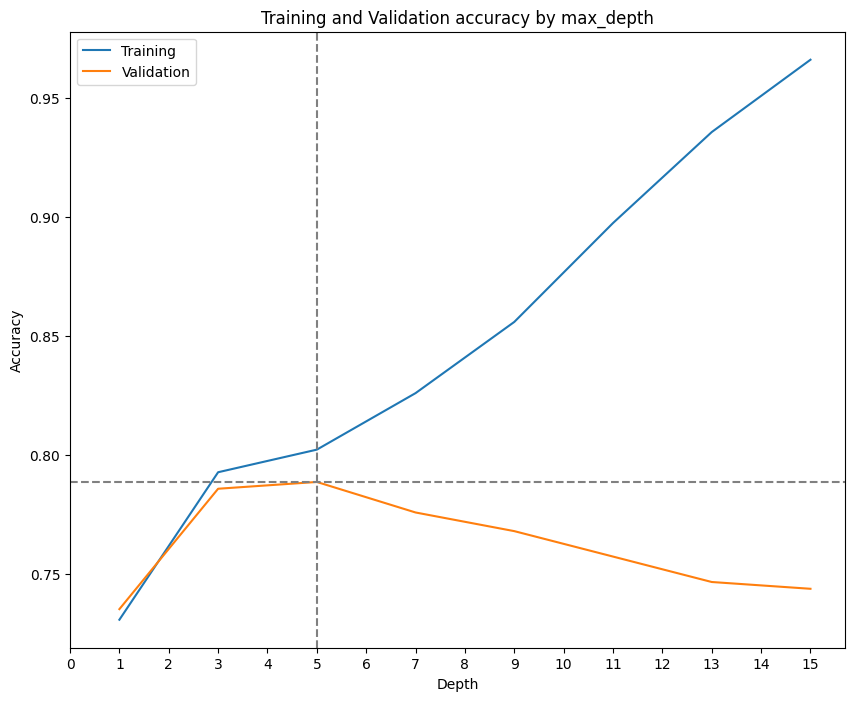

In [26]:
# plot validation and training accuracies vs depth
plt.figure(figsize=(10, 8))
plt.plot(
    depth_params,
    train_acc,
    label='Training'
)
plt.plot(
    depth_params,
    valid_acc,
    label='Validation'
)

plt.legend()

#set the titles and labels
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy by max_depth')

plt.xticks(range(0, 16,1))

# verticle and horizontal line showing the max validation accuracy
plt.axvline(5, color='grey', linestyle='--')
plt.axhline(max(valid_acc), color='grey', linestyle='--');

The maximum depth for optimum accuracy values is 5, with a training accuracy of 0.8023228253140554 and a validation accuracy of 0.7887624466571835.



In [27]:
# training decision tree classifier using a max_depth of 5
final_model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(
        max_depth=5,
        random_state=42
    )
)

final_model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'Partner', 'Dependents',
                                      'PhoneService', 'MultipleLines',
                                      'InternetService', 'OnlineSecurity',
                                      'OnlineBackup', 'DeviceProtection',
                                      'TechSupport', 'StreamingTV',
                                      'StreamingMovies', 'Contract',
                                      'PaperlessBilling', 'PaymentMethod'],
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2...
Month-to-month    2
One year          3
NaN              -2
dtype: int64},
                                         {'col': 'PaperlessBilling',
                                          'data_type': dtype('O'),
                                          'mapping': Yes    1
No     2
NaN   -2
dtype: int64},
                                         {'col': 'PaymentMethod',
                                          'data_type': dtype('O'),
                                          'mapping': Credit card (automatic)      1
Bank transfer (automatic)    2
Electronic check             3
Mailed check                 4
NaN                         -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

In [28]:
# predict
y_pred = final_model.predict(X_test)

In [29]:
# prediction accuracy
prediction_acc = accuracy_score(y_test, y_pred)

print('Prediction Accuracy:', prediction_acc)

Prediction Accuracy: 0.7810945273631841


In [64]:
# check F1 score
f_score = f1_score(y_test, y_pred, pos_label='Yes')
print('F1 Score:', f_score)

F1 Score: 0.5671641791044776


### Random Forest Classifier



In [65]:
# create train test data
target = 'Churn'
X = df.drop(columns=target)
y = df[target]

In [66]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [67]:
y_train.shape

(4219,)

In [68]:
# create a pipeline
model = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42)
)
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'Partner', 'Dependents',
                                      'PhoneService', 'MultipleLines',
                                      'InternetService', 'OnlineSecurity',
                                      'OnlineBackup', 'DeviceProtection',
                                      'TechSupport', 'StreamingTV',
                                      'StreamingMovies', 'Contract',
                                      'PaperlessBilling', 'PaymentMethod'],
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2...
                                          'mapping': Two year          1
Month-to-month    2
One year          3
NaN              -2
dtype: int64},
                                         {'col': 'PaperlessBilling',
                                          'data_type': dtype('O'),
                                          'mapping': Yes    1
No     2
NaN   -2
dtype: int64},
                                         {'col': 'PaymentMethod',
                                          'data_type': dtype('O'),
                                          'mapping': Credit card (automatic)      1
Bank transfer (automatic)    2
Electronic check             3
Mailed check                 4
NaN                         -2
dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [69]:
# baseline accuracy
baseline_acc = y_train.value_counts(normalize=True).max()
baseline_acc

0.7309789049537805

In [70]:
# depth values
depth_values=range(1,16,2)
train_acc =[]
val_acc = []

for depth in depth_values:
  model = make_pipeline(
      OrdinalEncoder(),
      RandomForestClassifier(random_state=42, max_depth=depth)
  )

  # train the model
  model.fit(X_train, y_train)

  # test accuracy
  train_acc.append(model.score(X_train, y_train))
  val_acc.append(model.score(X_val, y_val))

print('Training accuracy:', train_acc)
print('Validation accuracy:', val_acc)

Training accuracy: [0.7309789049537805, 0.7899976297700877, 0.8065892391561982, 0.8219957335861579, 0.8592083432092913, 0.9051908035079402, 0.9725053330173027, 0.9940744252192463]
Validation accuracy: [0.7354196301564723, 0.7780938833570412, 0.7894736842105263, 0.7958748221906117, 0.8001422475106685, 0.8008534850640113, 0.794452347083926, 0.7958748221906117]


In [71]:
max(val_acc)

0.8008534850640113

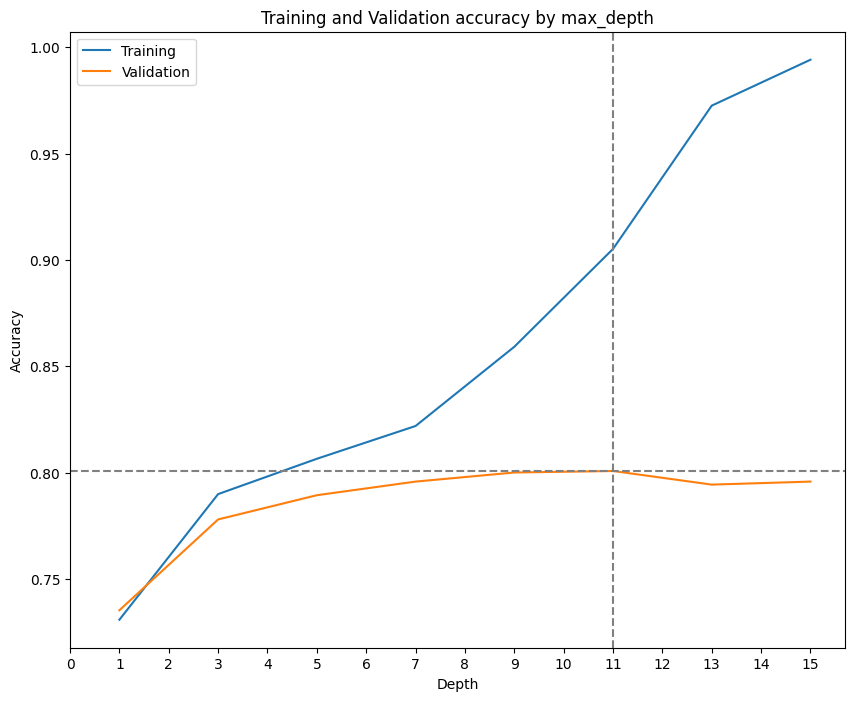

In [72]:
# plot validation and training accuracies vs depth
plt.figure(figsize=(10, 8))
plt.plot(
    depth_values,
    train_acc,
    label='Training'
)
plt.plot(
    depth_values,
    val_acc,
    label='Validation'
)

plt.legend()

#set the titles and labels
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy by max_depth')

plt.xticks(range(0, 16,1))

# verticle and horizontal line showing the max validation accuracy
plt.axvline(11, color='grey', linestyle='--');
plt.axhline(max(val_acc), color='grey', linestyle='--');

According to the plot above, the maximum depth for optimum accuracy values is 11, with a training accuracy of 0.9051908035079402 and a validation accuracy of 0.8008534850640113. Hence, making the Random Forest Classifier the ideal model for our classification problem.

In [73]:
# train model using  a max_depth of 11
final_model = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        max_depth=11,
        random_state=42
    )
)

final_model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'Partner', 'Dependents',
                                      'PhoneService', 'MultipleLines',
                                      'InternetService', 'OnlineSecurity',
                                      'OnlineBackup', 'DeviceProtection',
                                      'TechSupport', 'StreamingTV',
                                      'StreamingMovies', 'Contract',
                                      'PaperlessBilling', 'PaymentMethod'],
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2...
Month-to-month    2
One year          3
NaN              -2
dtype: int64},
                                         {'col': 'PaperlessBilling',
                                          'data_type': dtype('O'),
                                          'mapping': Yes    1
No     2
NaN   -2
dtype: int64},
                                         {'col': 'PaymentMethod',
                                          'data_type': dtype('O'),
                                          'mapping': Credit card (automatic)      1
Bank transfer (automatic)    2
Electronic check             3
Mailed check                 4
NaN                         -2
dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=11, random_state=42))])

In [74]:
y_pred = final_model.predict(X_test)

In [75]:
# prediction accuracy
prediction_acc = accuracy_score(y_test, y_pred)

print('Prediction Accuracy:', prediction_acc)

Prediction Accuracy: 0.7938877043354655


In [76]:
# check F1 score
f_score = f1_score(y_test, y_pred, pos_label='Yes')
print('F1 Score:', f_score)

F1 Score: 0.5671641791044776


In [78]:
# get feature names
features = X_train.columns

# get importances
importances = final_model.named_steps['randomforestclassifier'].feature_importances_

In [86]:
# create a series for features and importances
feature_importances = pd.Series(importances, index=features).sort_values()

feature_importances

PhoneService        0.004900
SeniorCitizen       0.015981
Partner             0.017043
Dependents          0.017997
gender              0.018663
MultipleLines       0.019476
DeviceProtection    0.021065
PaperlessBilling    0.021709
StreamingTV         0.026424
OnlineBackup        0.027159
StreamingMovies     0.028014
TechSupport         0.033673
OnlineSecurity      0.041268
PaymentMethod       0.043949
InternetService     0.051261
Contract            0.087162
MonthlyCharges      0.153787
TotalCharges        0.178015
tenure              0.192453
dtype: float64

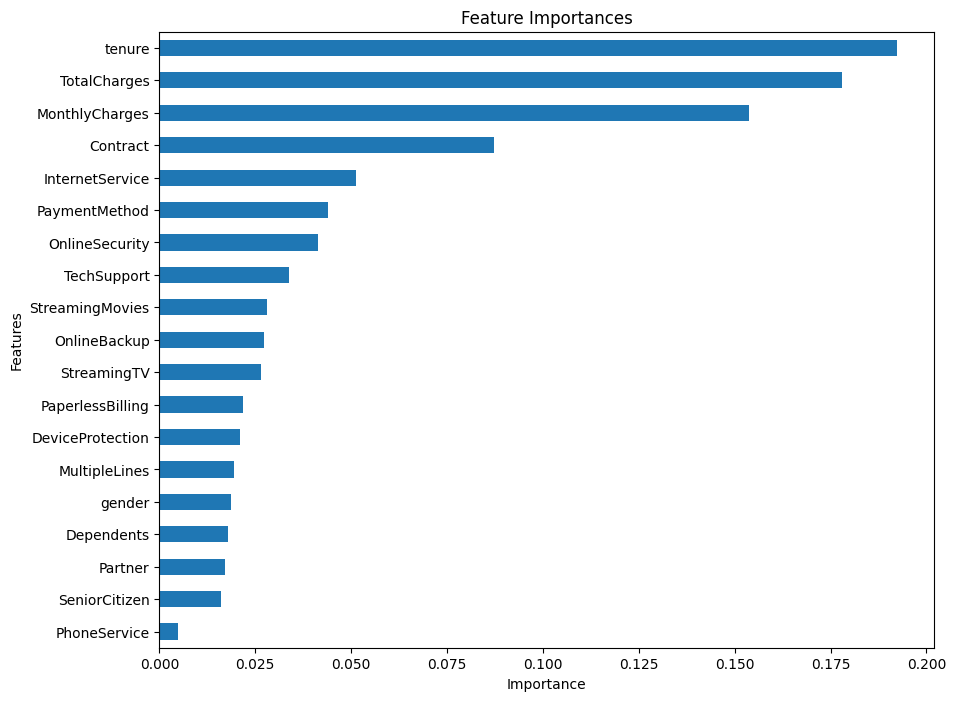

In [91]:
# plot features importances
plt.figure(figsize=(10,8))

feature_importances.plot(
    kind='barh'
)

plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances');

The above chart shows the contributors of customer churning. The highest contributor is tenure while the least is phone service.